# Final Project Part II: AX.25 and APRS
Written by Miki Lustig

Updated by Josh Sanz Spring 2022, Drake Lin Spring 2023
____

## Please read the text in this notebook carefully, there's lots of important detailed information everywhere. 

In this part of the project we are going to experiment with digital modulation and communication. Network communication systems have layered architectures. The bottom layer is the physical layer which implements the modulation. Here we will use your [AFSK](http://en.wikipedia.org/wiki/Frequency-shift_keying) modules that you implemented in Lab 4 Part I. In addition, we will leverage [AX.25](http://www.tapr.org/pub_ax25.html), which is an amateur-radio data-link layer protocol. [AX.25](http://www.tapr.org/pub_ax25.html) is a packet based protocol that will help us transmit data using packets. It implements basic synchronization, addressing, data encapsulation and some error detection.  In the ham world, an implementation of AFSK and [AX.25](http://www.tapr.org/pub_ax25.html)  together is also called a [TNC ( Terminal Node Controller )](http://en.wikipedia.org/wiki/Terminal_node_controller). In the past, TNCs were separate boxes that hams attached to their radios to communicate with packet-based communication. An example is [TNC-X](http://tnc-x.com). Today, it is easy to implement TNCs in software using the Raspberry Pi and a sound extension.... as you will see here! 


<img src="./TNCX.jpg" alt="Drawing" style="height: 300px;"/>

<center> Figure: Example of TNC-X, a Hardware Terminal Node Controller  </center>



# Pre-lab Setup
Since we can't guarantee that everyone will have access to a radio, a callsign, and an APRS IGate close enough for a radio to reach, we have adjusted this lab to emulate RF infrastructure with a popular software TNC called direwolf. Since direwolf was designed to be able to transmit and receive RF signals through a sound card, we can emulate an RF channel by connecting our code's transmissions to direwolf through an audio loopback. This section will set up direwolf and the audio loopback.

### Pre-task 1
We create an audio loopback with the command
```sh
sudo modprobe snd_aloop
```
You can check that it was successful with
```sh
aplay -L | grep -i plughw:card=loopback
aplay -l | grep -i loopback
```

Run the commands below and ensure the loopback exists.

In [3]:
!sudo modprobe snd_aloop
!aplay -L | grep -i plughw:card=loopback
!aplay -l | grep -i loopback

plughw:CARD=Loopback,DEV=0
plughw:CARD=Loopback,DEV=1
card 2: Loopback [Loopback], device 0: Loopback PCM [Loopback PCM]
card 2: Loopback [Loopback], device 1: Loopback PCM [Loopback PCM]


- **Record the card number** for use in the direwolf config file in case you have problems. 

### Pre-task 2
Now, we need to find your GPS coordinates. Direwolf will register the position on the APRS-IS network. The APRS-IS server filter will only send packets to your Direwolf server if the stations are within 50km radius (you don't want to get position reports from the entire world, do you?). So, it is important that you use the same position throghout the lab (later we will use position again). 

We will use `geopy` to convert an address to a coordinate.
* **Enter your address, or Cory Hall, below.**

In [4]:
# Enter your address here
myaddress = "6433 Telegraph Ave Oakland CA USA"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="EE123")
location = geolocator.geocode(myaddress, timeout=None)

In [5]:
# hopefully it did not fail
print(location.address)
print((location.latitude, location.longitude))

6433, Telegraph Avenue, Oakland, Alameda County, CAL Fire Northern Region, California, 94705, United States
(37.85090385, -122.2607547131212)


APRS uses degree,minutes.XX type format,  so we need to convert the coordinates. Use the following code to convert. 
* **Record the result to be used in the direwolf config file.**

In [6]:
import math
lat = "lat=%d^%2.2f%s" % (int(abs(location.latitude)),
                          60*(abs(location.latitude) - abs(math.floor(location.latitude))),
                          ("N") if location.latitude >0 else "S" )  
long = "long=%d^%2.2f%s" % (int(abs(location.longitude)),
                            60*(abs(location.longitude) - math.floor(abs(location.longitude))),
                          ("W") if location.longitude <0 else "E" )  
                            
print(lat, long)

lat=37^51.05N long=122^15.65W


### Pre-task 3
In order to be verified by the APRS-IS network, you need a passcode that is associated with your call sign. The following code is adapted from https://github.com/rossengeorgiev/aprs-python/blob/master/aprslib/passcode.py to produce this code. Input your callsign (provided by the course staff along with an SSID) and record the passcode to be used in the direwolf config file. 

An SSID is a number used to distinguish individual transmitters operated with a single callsign. Using an SSID, you could have a repeater at home, a weather station nearby, and an APRS-enabled handheld radio all sending packets with your callsign, but still be distinguishable. SSIDs are formatted as `CALSGN-#`, e.g. `KK6MRI-1`.

* **Enter your SSID, change the comment if desired, and record the passcode.**

In [7]:
# enter your callsign and comment for the beacon
callsign = "EE1235-1"
comment = "EE123 test"

# generate passcode
callsignr = callsign.split('-')[0].upper()
code = 0x73e2
for i, char in enumerate(callsignr):
    code ^= ord(char) << (8 if not i % 2 else 0)

passcode = code & 0x7fff
print("Passcode:", passcode)

Passcode: 13472


* **Use the above information to update the config file for direwolf.**

In [8]:
import os

cmd = "cat direwolf-loopback-DRAFT.conf  | sed  's/EE123_CALL/"+callsign+"/g'  | "
cmd = cmd +  "sed  's/EE123_PASSCODE/%d/g' | " % (passcode)
cmd = cmd +  "sed  's/EE123_COMMENT/comment=\"%s\"/g' | " % (comment)
cmd = cmd +  "sed  's/EE123_LATCOORD/%s/g' | " % (lat)
cmd = cmd +  "sed  's/EE123_LONGCOORD/%s/g' > direwolf-loopback.conf" % (long)
print(cmd)
os.system(cmd)  # NOTE: this is poor security practice, but conveniently concise here

cat direwolf-loopback-DRAFT.conf  | sed  's/EE123_CALL/EE1235-1/g'  | sed  's/EE123_PASSCODE/13472/g' | sed  's/EE123_COMMENT/comment="EE123 test"/g' | sed  's/EE123_LATCOORD/lat=37^51.05N/g' | sed  's/EE123_LONGCOORD/long=122^15.65W/g' > direwolf-loopback.conf


0

### Pre-task 4
Once you have edited the config file, start a terminal (either via SSH or in Jupyter from the directory page), change to this directory, and run
```sh
./run-direwolf.sh
```

Leave direwolf running while you are working on the lab. You can close it with control-c once you are finished.

* **Go to  http://igen2.eecs.berkeley.edu:14501 and make sure your callsign+ssid appears under clients.**

# IMPORTANT:
## Unless you have a ham license, do not change the IGSERVER setting in the direwolf config away from our igen2 server. Your packets may be illegally broadcast over the air if you do this! 
### IF you have a ham license AND you change the setting, MAKE SURE you are using your actual FCC callsign, not the one assigned by the course staff.

# Main Tasks

In [87]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import queue as Queue
import threading
import time
import sys
import multiprocessing

from numpy import ones, zeros, pi, sin, cos, exp, sign, r_, mean, power
from numpy.fft import fft, fftshift, ifft, ifftshift
from scipy import signal
from scipy import integrate

import bitarray
from scipy.io.wavfile import read as wavread
import ax25
from math import gcd
import sounddevice as sd
import RPi.GPIO as GPIO
from functools import reduce

%matplotlib inline

For the following tasks you will need the functions:

`sg_plot`  included below

`myspectrogram_hann_ovlp` included below

`afsk1200` (from Lab 4 Part I)

`nc_afsk1200Demod` (from Lab 4 Part I)

`PLL` (from Lab 4 Part I)

In [88]:
# function to compute least common multiple
def lcm(numbers):
    return reduce(lambda x, y: (x*y)//gcd(x,y), numbers, 1)

# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = (len(x)//N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X)**2,axis=0)

# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=plt.figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig

def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),np.ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    xmw = x * np.hanning(m)[:,None];
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m//2,:],dbf=dbf)
        print (1)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

In [89]:
def afsk1200(bits, fs=48000):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at fs Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal samples at fs Hz
    
    fss = lcm((1200,fs))
    deci = fss//fs
    
    Nb = fss//1200
    nb = len(bits)
    NRZ = ones((nb,Nb))
    for n in range(0,nb):
        if bits[n]:
            NRZ[n,:]=-NRZ[n,:]
    
    freq = 1700 + 500*NRZ.ravel()
    ph = 2.0*pi*integrate.cumtrapz(freq)/fss
    sig = cos(ph[::deci])
    
    return sig

    
def nc_afsk1200Demod(sig, fs=48000.0, TBW=2.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    N = (int(fs/1200*TBW)//2)*2+1
    BW = 1200
    h_lp = signal.firwin(N,BW/fs*1.0,window='hanning')
    h_lpp = signal.firwin(N,BW*2*1.2/fs,window='hanning')
    h_space = h_lp*exp(1j*2*pi*(2200)*r_[-N/2:N/2]/fs)
    h_mark = h_lp*exp(1j*2*pi*(1200)*r_[-N/2:N/2]/fs)
    h_bp = (signal.firwin(N,BW/fs*2.2,window='hanning'))*exp(1j*2*pi*1700*r_[-N/2:N/2]/fs)
    
    sig = np.convolve(sig,h_bp,'same')
    NRZ = abs(np.convolve(sig,h_mark,mode='same')) - abs(np.convolve(sig,h_space,mode='same'))
    NRZ = np.convolve(NRZ,h_lpp,'same')

    return NRZ


def PLL(NRZa, a=0.74, fs=48000, baud=1200):
    Ns = 1.0*fs/baud
    idx = zeros(len(NRZa)//int(Ns)*2)   # allocate space to save indexes
    lock = zeros(len(NRZa)//int(Ns)*2)
    c = 0
    dpll = np.round(2**32 / Ns).astype(np.int32)
    pll = np.int32(0)
    ppll = pll - dpll
    
    for n in range(1,len(NRZa)):
        if (pll < 0) and (ppll >0):
            idx[c] = n
            c = c+1        
        if (NRZa[n] >= 0) !=  (NRZa[n-1] >=0):
            pll = np.int32(pll*a)
        ppll = pll
        pll = np.int32(pll+ dpll)
    
    return idx[:c].astype(np.int32)


* **Find the audio interface numbers for the Fe-Pi and loopback.** 
* **Initialize the variables `usb_idx`, `loop_idx[_rcv]`, and `builtin_idx`.** `loop_idx` should be dev 1 and `loop_idx_recv` dev 0 of the loopback. `builtin_idx` is the `bcm2835 Headphones` device.


In [90]:
sd.query_devices()

   0 bcm2835 Headphones: - (hw:0,0), ALSA (0 in, 8 out)
   1 Fe-Pi Audio: HiFi sgtl5000-0 (hw:1,0), ALSA (2 in, 2 out)
   2 Loopback: PCM (hw:2,0), ALSA (32 in, 32 out)
   3 Loopback: PCM (hw:2,1), ALSA (1 in, 1 out)
   4 sysdefault, ALSA (0 in, 128 out)
   5 lavrate, ALSA (0 in, 128 out)
   6 samplerate, ALSA (0 in, 128 out)
   7 speexrate, ALSA (0 in, 128 out)
   8 pulse, ALSA (32 in, 32 out)
   9 upmix, ALSA (0 in, 8 out)
  10 vdownmix, ALSA (0 in, 6 out)
  11 dmix, ALSA (0 in, 2 out)
* 12 default, ALSA (32 in, 32 out)

In [91]:
builtin_idx = 0
usb_idx = 1
loop_idx = 3  # Use loopback dev 1! direwolf is connected to dev 0.
loop_idx_rcv = 2  # Use loopback dev 0. 
sd.default.samplerate = 48000
sd.default.channels = 1

## AX.25 (from: http://n1vg.net/packet/ and http://www.tapr.org/pub_ax25.html)

Before we go to demodulate AFSK1200 we will construct data in the form of AX.25 packets. The structure of the AX.25 packet, and in particular the flag that starts and ends a frame will help us sync to the beginning of the packet for accurate demodulation. 
The AX.25 protocol uses several measures for standardization and to improve detection and demodulation of packets. We will go over them now:

#### NRZI (non-return to zero inverted)
AX.25 does not encode  NRZ '1's and '0's in the usual mark and space frequencies. Instead it uses a scheme called NRZI, or non-return to zero inverted.  NRZI encodes a '0' bit as a change from mark to space, or space to mark. A '1' is encoded as no change.  To encode an AX.25 packet we need to convert our bit sequence to an NRZI one.  For example, an original bit stream of 11011000 should be first converted to 11000101 (initial state is 1). 

#### Bit Stuffing
Because a '1' is represented by no change, sending a long string of '1's would result in a constant signal. Receivers, similar to the one you designed in Lab 4, use phase-locked-loops to synchronize on bit changes. So a long constant signal may result in a receiver drifting out of sync with the transmitter. In order to circumvent this, the encoder performs bit stuffing before transmition by placing a '0' bit after every fifth '1' in the the stream. The decoder does bit unstuffing and removes the extra '0's. Bit stuffing is performed before converting to NRZI.

#### Bit Order
Bytes are sent least-significant-bit first

#### Flag
A Flag field starts and ends each packet. It is a unique sequence and is used to detect the beginning and the end of packets. The flag consists of the bit sequence: 0x7E or: 01111110. The flag is an exception in which no bit stuffing is performed. Therefore it is the only place in the packet in which 6 consecutive '1's appear. In NRZI it will translate to a time interval of 7 bits between zero-crossings of the non-coherent detector output.  This means that we can use the flag sequence to uniquely detect the beginning and the end of a packet. 

#### Frame Structure
The AX.25 protocol defines several types of frames, or packets. We will use the Un-numbered Information (UI) frame as defined in the protocol. A UI frame is used for connectionless mode, where AX.25 frames are transmitted without expecting any response, and reception is not guaranteed. This is similar to UDP in concept (however UDP is a transport layer protocol).
The  [Automatic Positioning and Reporting System (APRS)] (http://en.wikipedia.org/wiki/Automatic_Packet_Reporting_System) protocol uses UI frames. The UI frame has 9 fields of data:

| flag | Dest. Addr. | Src. Addr. |Digipeater Addresses | Control field | ID | Information Field | FCS | Flag |
|----:|-----------:|----------:|:------------------:|:-------------:|:--:|:-----------------:|:---:|:----:|
|1     |     7       |     7      |    56              |       1       |  1 |     256           |  2  |  1   |

Of particular importance are the Source address which is your call sign, the Information Field which is the packet payload, and the FCS which is an error checksum.

#### FCS Field
The FCS field is always the last two bytes in the packet. They are a checksum that can be used to determine the integrity of the packet, i.e., if an error in some of the bits has occured.


---
The following describes a system implementation that is based on the AX.25 protocol. It is called APRS, which stands for Automatic Positioning and Reporting System.

## Automatic Positioning and Reporting System (APRS) (information from: [Here](http://www.aprs.org/doc/APRS101.PDF) and [here](http://www.aprs.org/iss-aprs/issicons.html))
APRS is a ham packet-based system for real-time tactical digital communication for local area. APRS uses the AX.25 protocol in its core. Using APRS you can report position, status, and send messages that other hams or stations with APRS capability will be able to decode, interpret and display the information. APRS also provides means of packet repeating (Digipeaters) alongside internet terminal nodes. Some radio manufacturers saw the potential and included APRS in some of their products as well. Go to [this website](https://aprs.fi) to see the APRS activity in the surrounding area that is aggregated from the internet nodes. You will see fixed stations, weather stations, and mobile operators in your area. 

### Frequencies
The national APRS frequency is 144.39MHz. There is much activity and infrastracture transmitting and listenning to that frequency. The international space station also has an APRS digipeater on board operating at 145.825MHZ. 

### APRS Destination, Source, Digipeater Address, Control, ID and FCS packet fields
APRS uses AX.25 with UI packets. This enables the use of any AX.25 modem with APRS. But the content of the UI packets is unique to APRS, and the information is used in a very particular way.

#### Destination
For APRS packets, the Destination Address field is not used for routing. Instead it represents the version of the APRS software you are using. In order to be decoded by receivers in the APRS network it must start with the letters AP. We will use **`APCAL`** just for fun. 

#### Source
The Source Address is **your call sign**. 

#### Digipeater Address
The Digipeater Addresses require some explanation, but the fields 'WIDE1-1,WIDE2-1' will result in the packet being digipeated a maximum of 2 hops. Using 'WIDE1-1' will result in a single hop which, in densely populated areas like the Bay Area, is enough to get your packet to its destination. 

#### Control and ID
The Control and ID fields in APRS packets are fixed to "\x03" and "\xF0" respectively. 

#### FCS 
The FCS field is the checksum field that is used to verify the packet integrity, as defined by AX.25. 

The flag fields are the usual 01111110.

We have prepared for you code that generates a valid bitstream of AX.25 packets from the appropriate fields as well as decodes the fields from a bitstream. The code is a modification of code originally written by Greg Albrecht W2GMD. 

* **Make sure you have the file ``ax25.py`` in your working directory**

 
### The APRS information field
The information field of the packet is a 256 byte payload that contains the information you want to send. We will go over some of the information that is needed to construct valid and useful information field messeges. There are several digipeaters in the Bay Area that have internet terminal nodes. These implement several "fun" and useful services. For example, you can send a position report that would show up on a google map. You can also send a short EMAIL or an SMS test message by sending an APRS packet. In fact, we have our own APRS internet terminal node on Cory Hall!

How a node or a client interprets your packet depends on the information field structure. The APRS system considers three types of packets: Position, Status and Message.

#### Messages
The format of a message payload is the following:

Just begin your packet line with a colon and a 9 character TOADDRESS, another colon and then text. 
The TOADDRESS must have 9 characters and should be filled with spaces if it is smaller. 

Examples of messages:

* :ALL❏❏❏❏❏❏:Everyone with capable radios that capture this message will display this text.
* :KK6MRI❏❏❏:This message will only show on Miki's APRS enabled Yaezu VX-8dr radio screen
* :SMSGTE❏❏❏:@1234567890 This message will be sent as an SMS to the number
* :WXBOT❏❏❏❏:94720 The message to WXBOT will result in an APRS message sent back to you with weather information in Berkeley. You will need to be receiving APRS messages at the time!

The "❏❏❏❏❏" are blank spaces to fill the field to 9 characters.  

Here's a link for information about [SMSGTE](https://smsgte.wixsite.com/smsgte) and [WXBOT](https://sites.google.com/site/ki6wjp/wxbot)

Some radios implement message numbering, so packet repetition can be tracked. To number your message add the curly bracket symbol followed by the number. Often servers will acknowledge by sending you a confirmation back. 

For example, the first time you want to send an email to someone put `{1` at the end of the message. second time put `{2`, etc. 
* :EMAIL-2❏❏:someone@berkeley.edu This message will send that person an email{1


#### Position
You can report your position to people on the APRS system. If your report is picked up by a node it will show up on http://www.aprs.fi. The basic format of a position packet is:

| ! or = symbols | Latitude 8 chars | / | Longitude 9 chars| icon 1 char| Comment max 43 chars |
|---------------|-------------------|---|------------------|------------|----------------------|
| =             | 3752.50N|        /| 12215.43W|            K|Shows a school symbol on Cory Hall position|
| =             |3752.45N |/|12215.98W|[|Shows a person walking on Oxford and Hearst|
| =             |2759.16N |/|08655.30E|[|I'm on the top of the world! (Mt. Everest)|

The latitude format is expressed as a fixed 8-character field, in degrees and decimal minutes (up to two decimal places), followed by a letter N for north and S for south. Latitude minutes are expressed as whole minutes and hundredths of a minute, separated by a decimal point. Longitude is expressed as a fixed 9-character field, in degrees and decimal minutes (to two decimal places), followed by the letter E for east or W for west. Longitude degrees are in the range 000 to 180. Longitude minutes are expressed as whole minutes and hundredths of a minute, separated by a decimal point.

In generic format:

* Latitude is expressed as: ddmm.hhN (i.e. degrees, minutes, and hundredths of a minute north)
* Longitude is expressed as: dddmm.hhW (i.e. degrees, minutes, and hundredths of a minute west)

For example Cory Hall is at N37° 52.5022', W122° 15.4395'. So the position is encoded as:
3752.50N/12215.43W

You can go to http://www.gpsvisualizer.com/geocode to find the coordinates of an address. Note: use the degree, minutes representation, not the decimal one. https://www.pgc.umn.edu/apps/convert/ will help you convert between decimal degrees and degress decimal minutes.

a 1 character icon is provided after the coordinates. This will show an icon on the http://aprs.fi maps. Here are some useful ones:

* \- House with a VHF vertical
*  < Motorcycle
* \> Car
* Y Sailboat
* b Bike
* [ Jogger, walker, runner
* X Helo
* K School

Examples:

a school symbol 
* =3752.50N/12215.43WK Shows a school symbol on Cory Hall position.
* =3752.45N/12215.98W[ Shows a person walking on Oxford and Hearst
* =3752.❏❏N/12215.❏❏- Shows a house symbol somewhere in Berkeley.

** The empty squares ❏ represent space characters **

#### Status
A status packet starts with a '>' character. It wil show on APRS equipped radios. 

Examples:

*  \>I like radios
*  \>Monitoring 146.430MHz PL 66
*  \>On My way home


## Your first APRS packet
In the following section we will construct a valid (bitstuffed) bitstream from the different APRS packet fields. We will convert to an NRZI representation and modulate to generate a valid AFSK1200 APRS Packet.

### Bitstream from APRS fields

The following code shows you how to construct a message packet that will tell a digipeater to send you an SMS message. Make sure you fill the correct information in the fields. The bitstream will already be bitsuffed with zeroes. 
(SMSGTE, the server that sends SMS messages has added many features. Take a look at https://smsgte.org for more info)

* Be aware that sending a message to your own phone number will also mean that this number will show on the APRS network logs.

**NOTE:** Since you don't have ham radio licenses, we can't transmit messages to the public APRS internet backbone, and thus **the SMS/email/https://aprs.fi services will not work.** We recommend obtaining a license and trying these features out for yourself!

* **Enter your callsign and create the APRS packet bitstream.**

In [92]:
# Enter your callsign, with SSID 2
callsign = "EE1235-1"
Digi = b'WIDE1-1,WIDE2-1'
dest = "APCAL"

# Uncomment to Send an SMS message to a phone number (update the number!)
# info = ":SMSGTE   :@1234567890  Hey Friend I love EE123!{1"

# Uncomment to send an email (update the email!)  leave the {1 at the end. You will see a reply from the server 
# on Direwolf. If you send more messages, increment the number {2 , {3 etc.

# info = ":EMAIL-2  :drakelin@berkeley.edu EE123 is fun!{1"

# uncomment to send to everyone on the APRS system near you
# info = ":ALL      : CQCQCQ Hello world!"

# uncomment to report position -- change the coordinate based on what you got previously
# info = "=3751.05N/12215.65W-test"

# uncomment to send a status message
#info = ">I like radios"

packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet)
print('==>')
print(packet.unparse())

EE1235-1>APCAL,WIDE1-1,WIDE2-1:=3751.05N/12215.65W-test
==>
bitarray('011111100100000100000101011000010100000100011001000000100000011001010001010100010100011000100110011001100101011001000110011101010100100100010001010100010100011000000010010001100111010101001001000100010101000100100110000000101100011011000000000011111001111001100110011101100101011001000110001110100000011001010110001110010111101001000110001001100010011001000110010101100011101000110110010101100111010101011010000101110101001101100111000101110010011110001111001111110')


### Converting a stream of bits to NRZI
Recall that AX.25 packets are sent with NRZI encoding in which a '0' is a change and a '1' is no change. 

* The following function `NRZI = NRZ2NRZI(bits)`,  takes a standard bitarray stream and converts it to a bitarray stream representing '0's as change and '1's as unchanged. For example, an input of 0000111100 will result in 0101111101. This assumes an initial state of '1'. 
* The function `NRZI2NRZ(NRZI, current = True)`, takes an NRZI bitstream and converts it to an NRZ. It assumes an inital state of `current` with default `current=bool(1)`.


In [93]:
def NRZ2NRZI(NRZ):
    
    NRZI = NRZ.copy() 
    current = True
    for n in range(0,len(NRZ)):
        if NRZ[n] :
            NRZI[n] = current
        else:
            NRZI[n] = not(current)
        current = NRZI[n]
    return NRZI

def NRZI2NRZ(NRZI, current = bool(1)):
    
    NRZ = NRZI.copy() 
    
    for n in range(0,len(NRZI)):
            NRZ[n] = NRZI[n] == current
            current = NRZI[n]
    return NRZ


### Constructing and Transmitting an APRS AX.25 Packet. 

Most packet radios and TNCs will pad packets with extra `flag` sequences before and after the packet, to allow for synchronization. Rarely, the padding would be with zero-bit sequences (This will translate into alternating between Mark and Space which also helps with synchronization). Zero-padding is a deviation from the APRS protocol, but is allowed in most receivers. We will also pad our packets. 

### Task 1:
* **Pad your packet with 40 flags in the begining and at the end.**
* **Construct an afsk1200 signal** at a sampling rate of 48 kHz out of the padded APRS packet we constructed. 
* **Play the audio through the portable speaker.** Make sure you use the built-in audio and not the sound extension. It will sound like an old modem (which is what it is!)
* **Plot its spectrogram** with a window size of 80 samples (2 bits). You should be able to see the bits. 

Here's a python trick to generate 40 flags:

``prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())``

In [94]:
prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
bits = bitarray.bitarray(prefix)
bits.extend(packet.unparse())
bits.extend(prefix)
print(bits)

bitarray('011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001000001000001010110000101000001000110010000001000000110010100010101000101000110001001100110011001010110010001100111010101001001000100010101000101000110000000100100011001110101010010010001000101010001001001100000001011000110110000000000111110011110011001100111011001010110010001100011101000000110010101100011100101111010010001100010011000100110010001100101011000111010001101100101011001110101010110100001011101010011011001110001011100100111100011110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111110011111100111111001111

In [95]:
msg = afsk1200(bits, fs=48000)

# play sound on builtin interface and listen through the speaker    
sd.play(msg*0.3,samplerate=48000,device=builtin_idx,blocking=True)

Display a spectrogram:


1


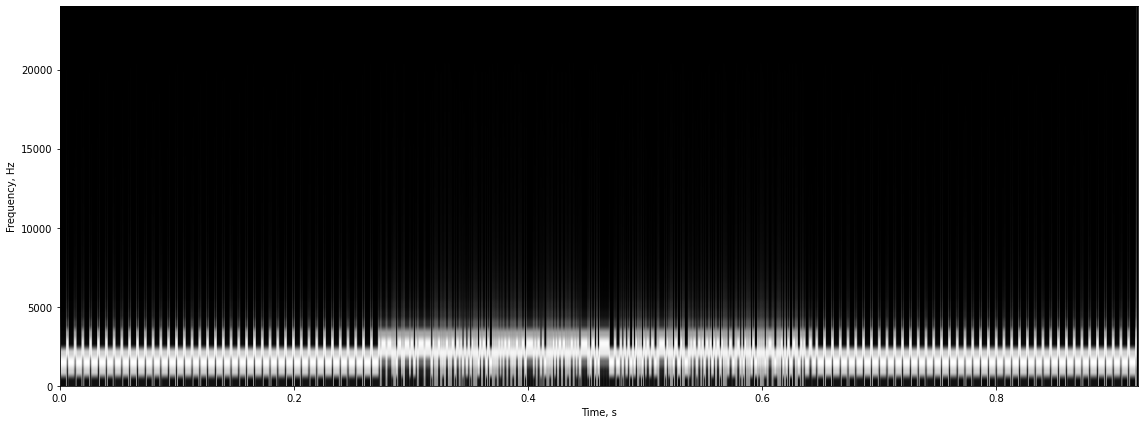

In [96]:
tt,ff,xmf = myspectrogram_hann_ovlp(msg, 80, 48000.0, 0, dbf=30)

### Task 2:

* **Make sure that direwolf is running.**
* **Send the APRS packet through the audio loopback.**
* **Make sure your output volume and settings are a "good choice"** (not too low but not too high). This means you need to scale your audio by a factor <1.0. We use 0.15

We include a time.sleep() call so that we don't DDOS the APRS-IS servers which run the internet backbone of APRS.

In [97]:
time.sleep(0.1)
sd.play(msg*0.15,samplerate=48000,device=loop_idx,blocking=True)

## [Optional]
The following Task 3 parts are optional. If you have a ham license, you may change your direwolf config to connect to the public infrastructure and try these services. Please talk to the course staff before sending to make sure you have direwolf configured correctly.

### [Task 3.1]:

* **Send an SMS message to yourself or your teammates**, give your name and a comment. 

##### You can also search for your callsign in https://aprs.fi. and then press the raw-packets link. It will show you all the packets received from you in the last 48 hours. (You will have to make an account for this). This is very useful for debugging!!!!!



In [124]:
# Send a message!

info = ":SMSGTE   :@1234567890   Hey Friend what's up!{1"

packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet)
print('==>')
print(packet.unparse())

prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
msg = afsk1200(NRZ2NRZI(prefix+packet.unparse()+prefix),fs=48000)
sd.play(msg*0.15,samplerate=48000,device=loop_idx,blocking=True)

### [Task 3.2]:
* **Send a position report** based on the position coordinates you got in the beginning.  -- Can you see yourself with the SSID-2 on aprs.fi?

In [125]:
# Send a position report

info = "=3752.50N/12215.42WlHi everyone!"

packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet)
print('==>')
print(packet.unparse())

prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
msg = afsk1200(NRZ2NRZI(prefix+packet.unparse()+prefix),fs=48000)
sd.play(msg*0.15,samplerate=48000,device=loop_idx,blocking=True)

### [Task 3.3]:

* **Send yourself an email**, send your parents or friends an email. 


In [126]:
# Send an email

info = ":EMAIL-2  :someone@berkeley.edu please give me an A+{1"

packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet)
print('==>')
print(packet.unparse())

prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
msg = afsk1200(NRZ2NRZI(prefix+packet.unparse()+prefix),fs=48000)
sd.play(msg*0.15,samplerate=48000,device=loop_idx,blocking=True)

### [Task 3.4]:

* **Send a status report message.**



In [127]:
# Send a status report

info = ">I like radios"

packet = ax25.UI(
		destination=dest,
		source=callsign, 
		info=info,
		digipeaters=Digi.split(b','),
        )
print(packet)
print('==>')
print(packet.unparse())

prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(40,)).tolist())
msg = afsk1200(NRZ2NRZI(prefix+packet.unparse()+prefix),fs=48000)
sd.play(msg*0.15,samplerate=48000,device=loop_idx,blocking=True)

## Decoding AX.25 and APRS Packets

Now that we know how to create AX.25 and APRS packets, know how to AFSK1200 modulate them, and know how to demodulate AFSK1200 as well, we can move forward to receiving and decoding packets. By the end of that we will have a fully functioning communication system.

Make sure the file `ISSpkt.wav` is in your working directoy. It contains an APRS packet Miki recorded on an International Space Station flyby. 
* **Load ISSpkt.wav** to your workspace using the function `wavread`, which we imported from `scipy.io`.


In [98]:
fs, sig = wavread("ISSpkt.wav")

We will now automate the packet decoding by writing some functions that implement portions of the process.

* **Run the function `nc_afsk1200Demod` on the ISS packet** to get the demodulated "analog" NRZI
* **Plot the signal.** It should look like a signal with $\pm$ positive negative switching!

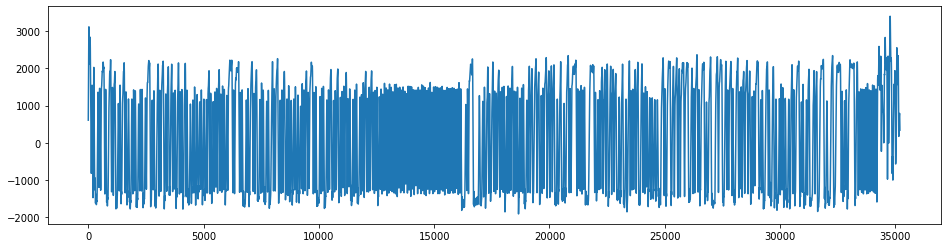

In [99]:
NRZIa = nc_afsk1200Demod(sig, fs)
fig = plt.figure(figsize=(16,4))
plt.plot(NRZIa);

### Decoding Bits from the Demodulated NRZI Signal

Once we have demodulated the signal, the next task is to sample and look for packets in it! There are many ways to do so. We chose one similar to the DireWolfe implementation:

* Use the PLL to determine where to sample and get an output NRZI bitstream.
* Convert the NRZI to NRZ
* Search the bits and look for flags that indicate the existance of a packet. Of course, there may be many false detections. Hence, consider any flag as the end of a packet, or beginning of a new one.
* Discard packets that are too short, or that the checksum does not match.

Below are several functions we wrote for you:

* `findPackets(bits)` - Searches a bitstream for possible valid packets
* `genfcs(bits)` - generates a checksum for validating packets
* `decodeAX25(bits)`  - Parses a packet bitstream into fields and decodes them

* **Study well these functions, and in particular `findPackets(bits)`.** You will need to modify it when performing stream processing.


In [101]:
def findPackets(bits):
        # function take a bitarray and looks for AX.25 packets in it.
        # It implements a 2-state machine of searching for flag or collecting packets.
                
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = 0
        pktcounter = 0
        packet = []
        state = 'search'
        
        # Loop over bits
        while (n < len(bits)-7) :
            
            # default state is searching for packets
            if state is 'search':
                
                # look for 1111110, because can't be sure if the first zero is decoded
                # well or if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    state = 'pkt'
                    packet=flg.copy()
                    pktcounter = 8                    
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1            
        
            # state is to collect packet data. 
            elif state is 'pkt':
                
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if pktcounter > 200:
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # false detection and this flag could be the beginning of a real packet
                        state = 'search'
                        packet.extend(flg)
                        packets.append(packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer                        
                        packet.append(bits[n])
                        pktcounter = pktcounter + 1
                        n = n + 1
                    else:  
                        #runaway packet, switch state to searching, and advance pointer
                        state = 'search'
                        n = n + 1
        return packets

    
# function to generate a checksum for validating packets
def genfcs(bits):
    # Generates a checksum from packet bits
    fcs = ax25.FCS()
    for bit in bits:
        fcs.update_bit(bit)
    
    digest = bitarray.bitarray(endian="little")
    digest.frombytes(fcs.digest())

    return digest


# function to parse packet bits to information
def decodeAX25(bits):
    ax = ax25.AX25()
    ax.info = "bad packet"
        
    # bits without pre/post - ambles
    bitsu = ax25.bit_unstuff(bits[8:-8])
    
    if (genfcs(bitsu[:-16]).tobytes() == bitsu[-16:].tobytes()) == False:
        #print("failed fcs")
        return ax
    
    bytes = bitsu.tobytes()
    ax.destination = ax.callsign_decode(bitsu[:56]).decode('ascii')
    source = ax.callsign_decode(bitsu[56:112]).decode('ascii')
    
    if source[-1].isdigit() and source[-1]!="0":
        ax.source = "".join((source[:-1],'-',source[-1]))
    else:
        ax.source = source[:-1]
    
    digilen=0    
    
    if bytes[14]=='\x03' and bytes[15]=='\xf0':
        digilen = 0
    else:
        for n in range(14,len(bytes)-1):
            if bytes[n] & 1:
                digilen = (n-14)+1
                break

#    if digilen > 56:
#        return ax
    ax.digipeaters =  ax.callsign_decode(bitsu[112:112+digilen*8]).decode('ascii')
    ax.info = bitsu[112+digilen*8+16:-16].tobytes().decode('ascii')
    
    return ax


### Task 4:

* **Use the pll to find the sampling index of the analog NRZI.**
* **Sample and convert to a bitarray** (True is positive NRZI, False is negative NRZI).
* **Convert the NRZI bits to NRZ.**
* **Use `findPackets` to find packets** in the bitstream.
* **Save the packet into the `packets` variable and run the following decoding cell.**

You should get this when decoding properly:

`1) | DEST:CQ    0 | SRC: RS0ISS | DIGI:  | ARISS - International Space Station |`

In [120]:
# Your code here:

samp_ind = PLL(NRZIa, fs=fs)
sample = list((NRZIa[samp_ind] > 0).astype(int))
bitarr = bitarray.bitarray(sample)
NRZ = NRZI2NRZ(bitarr)
packets = findPackets(NRZ)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in long_scalars


In [121]:
# Code to display packets

npack = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
            print(infostr)

 1) | DEST: CQ    0 | SRC: RS0ISS | DIGI:  | ARISS - International Space Station |


### Testing on more packets

Now, lets try our decoder on a noisy recording with many more packets. 

### Task 5:
* **Load the full recording of the pass**, which is stored in `ISS.wav`. It's a 3 min recording.   
* **Process the signal and decode all the packets.** Out decoder decodes 24 packets successfully

_In python, implementing the PLL with for loops is inefficient. You can still run your own PLL, but the processing time may be too long. Instead, we wrote a simple C function, which runs incredibly fast. We use the ctypes interface to call the C function from python.  Below is the code necessary to run the fast PLL.  FastPLL can replace the PLL you wrote. Make sure libpll.so is in your operating directory. Take a look at pll.c to see how it was implemented. It is very similar to the python version._

In [122]:
# Build libpll.so
!cc -fPIC -shared -o libpll.so pll.c

In [123]:
import numpy.ctypeslib as npct
from ctypes import c_int
from ctypes import c_float

array_1d_int = npct.ndpointer(dtype=np.int, ndim=1, flags='CONTIGUOUS')

libcd = npct.load_library("./libpll", ".")
libcd.pll.restype = c_int
libcd.pll.argtypes= [array_1d_int, c_int, array_1d_int,array_1d_int,  array_1d_int,array_1d_int, c_int, c_float]

In [124]:
def FastPLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):    
    
    Ns = 1.0*fs/baud
    dpll = np.round(2**32 / Ns).astype(np.int32)
    
    # allocate space for arrays and initialize pll variables
    recbits = np.zeros(len(NRZa)//(fs//1200)*2,dtype=np.int32)
    idx = np.zeros(len(NRZa)//(fs//1200)*2,dtype=np.int32)
    pll = np.zeros(1,dtype = np.int32)
    pll[0] = 0
    ppll = np.zeros(1,dtype = np.int32)
    ppll[0] =  -dpll
        
    NRZb = (NRZa > 0).astype(np.int32)
    tot = libcd.pll(NRZb,len(NRZb),recbits,idx,pll,ppll,dpll,a)
        
    return idx[:tot].tolist()

In [127]:
def afsk_to_packets(sig, fs):
    # This function demodulates, samplse, convert NRZI to NRZ, and find packets.
    
    # Your code here:
    
    NRZIa = nc_afsk1200Demod(sig, fs)
    samp_ind = FastPLL(NRZIa, fs=fs)
    sample = list((NRZIa[samp_ind] > 0).astype(int))
    bitarr = bitarray.bitarray(sample)
    NRZ = NRZI2NRZ(bitarr)
    packets = findPackets(NRZ)
    
    return packets



In [128]:
fs, sig = wavread("ISS.wav")
packets = afsk_to_packets(sig, fs)

In [129]:
# display packets

npack = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
                print(infostr)

 1) | DEST: CQ    0 | SRC: RS0ISS | DIGI:  | ARISS - International Space Station |
 2) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | =4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH! |
 3) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | >CQCQCQ |
 4) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | HELO VIA THE ISS |
 5) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 6) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 7) | DEST: ARISS p | SRC: KF1BUZ | DIGI: RS0ISSpAPRS  0WIDE2 2SGATE 0ISS   0IGATE 0PCSAT 0BEACON0 | =3932.15N/11951.16Wy.kf1buz and k1gem say hi from reno nv |
 8) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp |  |
 9) | DEST: CQ    0 | SRC: N7NEV  | DIGI: RS0ISSpWIDE2 2WIDE1 1 | >from DM43 |
 10) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | =4038.2604n/11155.90744w-HELLO FROM N7HQB IN SLC UTAH! |
 11) | DEST: CQ    p | SRC: N7HQB  | DIGI: RS0ISSp | HELLO VIA THE ISS |
 12) | DEST: CQ    0 | SRC: K7RFK  | DIGI: RS0ISSp | =4635.49N/12032.27W

#### Did you get 24 packets?

## Test Loop-back audio

The next step is to test a loop-back in which you send audio and also receive and decode audio.  

### Task 6:

* **Generate 3 flag-padded packets, with *different* information in them.** Have at least 40 flags before and after a packet. 
* **Create the afsk1200 signal for each of the packets.**
* Before you transmit, **add to the modulated message 5 seconds of zeros at the end.** (240,000 samples)




In [134]:
# Create 3 unique AX.25 packets
# Your code here:

def pad_packet(packet, length):
    prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(length,)).tolist())
    bits = bitarray.bitarray(prefix)
    bits.extend(packet.unparse())
    bits.extend(prefix)
    return bits

# uncomment to send a status message
info = [">snap", ">crackle", ">pop"]

dest = "APCAL"
callsign = "EE1235-1"

packets = [ax25.UI(
		destination=dest,
		source=callsign, 
		info=inf,
		digipeaters=Digi.split(b','),
        ) for inf in info]



In [135]:
# Add flags to packets, combine into one stream of samples, append zeros
# Your code here:

padded = [pad_packet(packet, 40) for packet in packets]
NRZIarr = NRZ2NRZI(padded[0] + padded[1] + padded[2])
msg = afsk1200(NRZIarr)


In [136]:
msg.shape

(115039,)

### Task 7:
* **Use ``sd.playrec`` to play and record the packets.** Adjust the audio level as needed. 
* **Decode the the packets from the recording.**
* Also, **make a plot of the beginning 5000 samples of the audio recording.** Make sure its not saturated!

Don't forget to use ``sig = sig.flatten()`` to turn it into size of ``(len(sig),)`` instead of ``(len(sig),1)``

In [137]:
# For software loopback
sig = sd.playrec(msg*0.2,samplerate=48000,device=(loop_idx, loop_idx_rcv),channels=1,blocking=True,dtype=np.float32)

# For direwolf loopback
# sig = sd.playrec(msg*0.2,samplerate=48000,device=loop_idx,channels=1,blocking=False,dtype=np.float32)

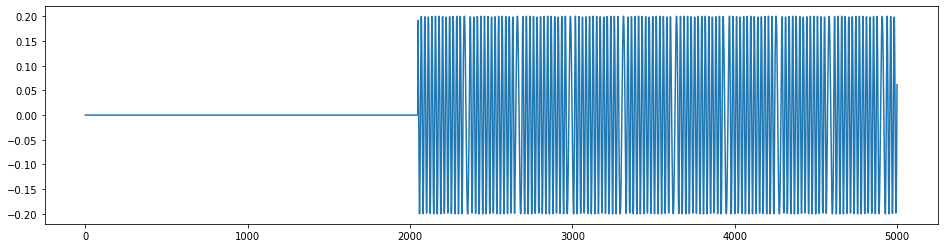

In [138]:
# Plot
sig = sig.flatten()
plt.figure(figsize=(16,4))
plt.plot(sig[:5000]);

In [139]:
# Decode packets
packets = afsk_to_packets(sig, 48000)

# display packets:

npack = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
                print(infostr)

 1) | DEST: APCAL 0 | SRC: EE1235-1 | DIGI: WIDE1 1WIDE2 1 | >snap |
 2) | DEST: APCAL 0 | SRC: EE1235-1 | DIGI: WIDE1 1WIDE2 1 | >crackle |
 3) | DEST: APCAL 0 | SRC: EE1235-1 | DIGI: WIDE1 1WIDE2 1 | >pop |


### Task 9:
Now run Direwolf again.  Direwolf repeats messages it gets from APRS-IS to be transmitted on the audio loopback device. So, if we record 60 seconds of audio from the device loop_idx while your partner or a classmate is sending messages, it is likely that we will record packets. 

* **Have your partner or a classmate transmit messages through direwolf.**
* **While recording sound, look at the Direwolf terminal and count the number of messages saying `[ig->tx]`.**
* **Decode the recorded messages.**

In [145]:
# Example transmit command for your partner
# sig = sd.play(msg*0.2,samplerate=48000,device=loop_idx,blocking=True)


In [146]:
sig = sd.rec(fs*60,samplerate=48000,device=loop_idx,channels=1,blocking=True,dtype=np.float32).flatten()

Decode the messages.

In [147]:
packets = afsk_to_packets(sig, 48000)

# display packets:
npack = 0
for pkt in packets:
        if len(pkt) > 200: 
            ax = decodeAX25(pkt)
            if ax.info != 'bad packet':
                npack = npack+1
                infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                        'n': npack,
                        'dest': ax.destination,
                        'src': ax.source,
                        'digi': ax.digipeaters,
                        'info': ax.info.strip()
                    }
                print(infostr)

In [148]:
plt.figure(figsize=(16,4))
plt.plot(sig[::480]);

Congratulations,  you created a modem!


## Next.... We will move to stream processing to make it useful.